# Format 2

In [1]:
# Load packages
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

# Load the data
train_data, train_label = sio.loadmat('train_32x32.mat')['X'], sio.loadmat('train_32x32.mat')['y']
test_data, test_label = sio.loadmat('test_32x32.mat')['X'], sio.loadmat('test_32x32.mat')['y']

img_count = train_data.shape[3]
channels = train_data.shape[2]

# Determine number of classes
n_classes = len(np.unique(train_label))

# Preprocessing: Histogram of Oriented Gradients Color

In [2]:
# Reshape PNGs into coloured 2D arrays
from skimage.feature import hog

def transform(image, active=False):
    return hog(image, 
               orientations = 9, 
               pixels_per_cell = (4, 4), 
               cells_per_block = (1, 1), 
               visualise = active, 
               transform_sqrt = True,
               block_norm='L2-Hys')

In [3]:
import time
train_time_start = time.time()
color_train = []
for i in range(img_count): 
    img_container = []
    for j in range(channels):
        features_train = transform(train_data[:,:,j,i], active=False)
        img_container.append(features_train)
    color_train.append(np.array(img_container).flatten())
color_train = np.array(color_train)
print("Features Train:", color_train.shape)
train_time_end = time.time() - train_time_start

Features Train: (73257, 1728)


In [8]:
print(np.round(train_time_end/60), 'minutes', np.round(train_time_end % 60), 'seconds')

6.0 minutes 16.0 seconds


In [9]:
test_time_start = time.time()
color_test = []
for i in range(test_data.shape[3]): 
    img_container = []
    for j in range(channels):
        features_test = transform(test_data[:,:,j,i], active=False)
        img_container.append(features_test)
    color_test.append(np.array(img_container).flatten())
color_test = np.array(color_test)
print("Features Test:", color_test.shape)
test_time_end = time.time() - test_time_start

Features Test: (26032, 1728)


In [10]:
print(np.round(test_time_end/60), 'minutes', np.round(test_time_end % 60), 'seconds')

2.0 minutes 10.0 seconds


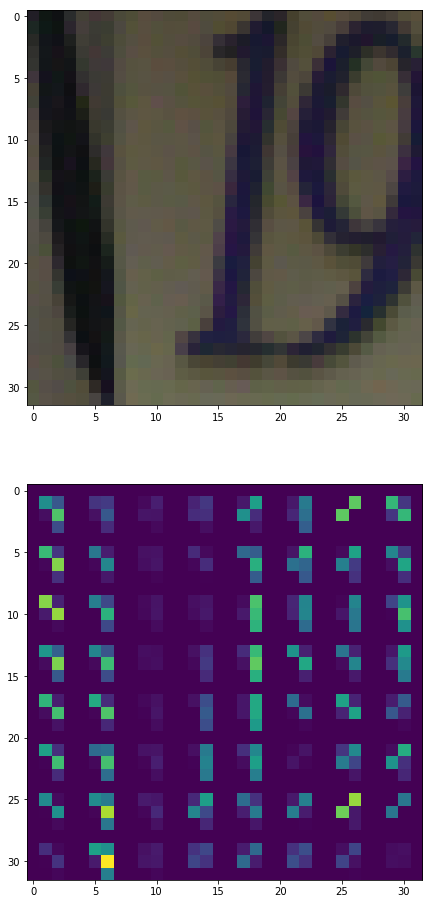

In [11]:
from skimage import exposure

# Render images and show
image = train_data[:,:,:,0]
_, hog_image = transform(train_data[:,:,0,0], active=True)
hog_image= exposure.rescale_intensity(hog_image, in_range=(0, 255))
fig, (ax1, ax2) = plt.subplots(2, sharey=True, figsize = (16,16))
ax1.imshow(image)
ax2.imshow(hog_image)

# Preprocessing: DCT

In [12]:
# Set partitions
partition_train = 73257
partition_test = 26032

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

In [164]:
from scipy.fftpack import dct

it = 8

# DCT features
dct_flat_train = []
dct_flat_test = []

for i in range(train_data.shape[3]):
    container_dct = []
    for j in range(0, train_data.shape[0], it):
        for k in range(0, train_data.shape[1], it):
            tile_train = (dct(train_data[j:j+it,k:k+it,:,i].reshape(3,it**2))).flatten()
            container_dct.append(tile_train)  
    container_dct = np.array(container_dct).flatten()
    dct_flat_train.append(container_dct)
    
for i in range(test_data.shape[3]):
    container_dct = []
    for j in range(0, test_data.shape[0], it):
        for k in range(0, test_data.shape[1], it):
            tile_train = (dct(test_data[j:j+it,k:k+it,:,i].reshape(3,it**2))).flatten()
            container_dct.append(tile_train)  
    container_dct = np.array(container_dct).flatten()
    dct_flat_test.append(container_dct)
    
dct_flat_train = np.array(dct_flat_train)
dct_flat_test = np.array(dct_flat_test)

# Scaled DCT
scaled_dct_train = scaler.fit_transform(dct_flat_train[:partition_train])
scaled_dct_test = scaler.fit_transform(dct_flat_test[:partition_test])

# Preprocessing: RGB Covariance Descriptor

In [13]:
# Initialize covariance matrices
cov_train = []
cov_test = []

# Iterating step
it = 16

cov_start_time = time.time()

# Loop
for i in range(train_data.shape[3]):
    img_matrix_train = []
    for j in range(0, train_data.shape[0], it):
        for k in range(0, train_data.shape[1], it):
            tile_train = (np.cov(train_data[j:j+it,k:k+it,:,i].reshape(3,it**2))).flatten()
            img_matrix_train.append(tile_train)  
    img_matrix_train = np.array(img_matrix_train).flatten()
    cov_train.append(img_matrix_train)
    
for i in range(test_data.shape[3]):
    img_matrix_test = []
    for j in range(0, test_data.shape[0], it):
        for k in range(0, test_data.shape[1], it):
            tile_test = (np.cov(test_data[j:j+it,k:k+it,:,i].reshape(3,it**2))).flatten()
            img_matrix_test.append(tile_test)  
    img_matrix_test = np.array(img_matrix_test).flatten()
    cov_test.append(img_matrix_test)    

# Convert to numpy arrays
cov_train = np.array(cov_train)
cov_test = np.array(cov_test)

# Print the shape
print('Train Matrix:',cov_train.shape)
print('Test Matrix:',cov_test.shape)

scaled_cov_train = scaler.fit_transform(cov_train[:partition_train])
scaled_cov_test = scaler.fit_transform(cov_test[:partition_test])

cov_end_time = time.time() - cov_start_time

Train Matrix: (73257, 36)
Test Matrix: (26032, 36)


In [15]:
print(np.round(cov_end_time/60), 'minutes', np.round(cov_end_time % 60), 'seconds')

1.0 minutes 42.0 seconds


# SVM Classifier

## HOG + Covariance

In [16]:
from sklearn.svm import LinearSVC
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(color_train[:partition_train])
Y = scaler.fit_transform(color_test[:partition_test])
Z = train_label[:partition_train].ravel()
XC = np.concatenate((scaled_cov_train, X), axis=1)
YC = np.concatenate((scaled_cov_test, Y), axis=1)
clf = LinearSVC(C=1)
HC_start_time = time.time()
clf.fit(XC,Z)
HC_end_time = time.time() - HC_start_time

In [17]:
print(np.round(HC_end_time/60), 'minutes', np.round(HC_end_time % 60), 'seconds')

21.0 minutes 45.0 seconds


In [29]:
XC_results = clf.predict(YC[:partition_test])
from sklearn import metrics as skm
XC_report = skm.classification_report(test_label[:partition_test], XC_results)
print( "Model Precision: {}%".format(round((skm.precision_score(test_label, XC_results, average="macro")*100), 2)) )
print( "Model Recall: {}%".format(round((skm.recall_score(test_label, XC_results, average = "macro")*100), 2)) )
print( "Model F-score: {}%".format(round((skm.f1_score(test_label, XC_results, average = "macro")*100), 2)) )
print( "Training Accuracy: {}%".format(np.round(clf.score(XC[:partition_test],Z[:partition_test])*100, 2)))
print( "Model Accuracy: {}%".format(np.round(clf.score(YC[:partition_test],test_label[:partition_test])*100, 2)))
print( "******************** Classification Report ********************" )
print(XC_report)

Model Precision: 61.38%
Model Recall: 58.39%
Model F-score: 56.47%
Training Accuracy: 75.47%
Model Accuracy: 60.6%
******************** Classification Report ********************
             precision    recall  f1-score   support

          1       0.83      0.72      0.77      5099
          2       0.86      0.63      0.73      4149
          3       0.65      0.42      0.51      2882
          4       0.68      0.62      0.65      2523
          5       0.51      0.71      0.59      2384
          6       0.40      0.65      0.50      1977
          7       0.66      0.69      0.67      2019
          8       0.55      0.13      0.21      1660
          9       0.29      0.75      0.42      1595
         10       0.70      0.50      0.58      1744

avg / total       0.67      0.61      0.61     26032



In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_label[:partition_test], XC_results)

array([[3685,   85,   87,  167,   97,  235,  168,   63,  368,  144],
       [ 102, 2633,  137,  147,  199,  196,  223,   41,  444,   27],
       [ 128,   91, 1224,   79,  419,  184,   78,   26,  614,   39],
       [ 115,   34,   74, 1575,   99,  301,   48,    9,  227,   41],
       [  45,   26,  101,   52, 1684,  218,   38,    8,  204,    8],
       [  54,   16,   62,  113,  281, 1294,   25,    3,  102,   27],
       [ 145,   95,   54,   31,   97,   80, 1392,   11,   97,   17],
       [  51,   32,   80,   72,  210,  461,   33,  212,  470,   39],
       [  32,   33,   34,   26,  114,   71,   43,    3, 1202,   37],
       [  70,   25,   33,   50,   83,  176,   77,    6,  350,  874]],
      dtype=int64)

## HOG

In [21]:
H_start_time = time.time()
clf2 = LinearSVC(C=1)
clf2.fit(X, Z)
H_end_time = time.time() - H_start_time

In [22]:
print(np.round(H_end_time/60), 'minutes', np.round(H_end_time % 60), 'seconds')

19.0 minutes 33.0 seconds


In [30]:
X_results = clf2.predict(Y[:partition_test])
X_report = skm.classification_report(test_label[:partition_test], X_results)
print( "Model Precision: {}%".format(round((skm.precision_score(test_label, X_results, average="macro")*100), 2)) )
print( "Model Recall: {}%".format(round((skm.recall_score(test_label, X_results, average = "macro")*100), 2)) )
print( "Model F-score: {}%".format(round((skm.f1_score(test_label, X_results, average = "macro")*100), 2)) )
print( "Training Accuracy: {}%".format(np.round(clf2.score(X[:partition_test],Z[:partition_test])*100, 2)))
print( "Model Accuracy: {}%".format(np.round(clf2.score(Y[:partition_test],test_label[:partition_test])*100, 2)))
print( "******************** Classification Report ********************" )
print(X_report)

Model Precision: 59.92%
Model Recall: 57.58%
Model F-score: 56.4%
Training Accuracy: 74.81%
Model Accuracy: 59.73%
******************** Classification Report ********************
             precision    recall  f1-score   support

          1       0.88      0.64      0.74      5099
          2       0.81      0.68      0.74      4149
          3       0.63      0.44      0.52      2882
          4       0.61      0.67      0.64      2523
          5       0.41      0.78      0.54      2384
          6       0.38      0.58      0.46      1977
          7       0.77      0.59      0.67      2019
          8       0.45      0.20      0.28      1660
          9       0.37      0.66      0.47      1595
         10       0.69      0.50      0.58      1744

avg / total       0.65      0.60      0.60     26032



In [24]:
confusion_matrix(test_label[:partition_test], X_results)

array([[3286,  123,  120,  292,  216,  285,  121,  172,  292,  192],
       [  63, 2823,  135,  205,  285,  172,   82,   79,  290,   15],
       [  69,  110, 1265,  127,  651,  169,   33,   49,  374,   35],
       [  52,   47,   85, 1701,  175,  265,   18,   24,  118,   38],
       [  17,   29,  105,   65, 1868,  175,   16,   15,   85,    9],
       [  31,   19,   69,  147,  467, 1143,   13,   19,   52,   17],
       [ 116,  185,   67,   51,  171,   96, 1199,   31,   76,   27],
       [  28,   39,   81,   81,  354,  424,   13,  336,  279,   25],
       [  20,   66,   44,   40,  209,   84,   25,   13, 1051,   43],
       [  54,   46,   39,   76,  162,  207,   31,   14,  238,  877]],
      dtype=int64)

## Covariance

In [25]:
C_start_time = time.time()
clf3 = LinearSVC(C=1)
C1=scaled_cov_train
C2=scaled_cov_test
clf3.fit(C1,Z)
C_end_time = time.time() - C_start_time

In [26]:
print(np.round(C_end_time/60), 'minutes', np.round(C_end_time % 60), 'seconds')

2.0 minutes 7.0 seconds


In [32]:
C_results = clf3.predict(C2[:partition_test])
C_report = skm.classification_report(test_label[:partition_test], C_results)
print( "Model Precision: {}%".format(round((skm.precision_score(test_label, C_results, average="macro")*100), 2)) )
print( "Model Recall: {}%".format(round((skm.recall_score(test_label, C_results, average = "macro")*100), 2)) )
print( "Model F-score: {}%".format(round((skm.f1_score(test_label, C_results, average = "macro")*100), 2)) )
print( "Training Accuracy: {}%".format(np.round(clf3.score(C1[:partition_test],Z[:partition_test])*100, 2)))
print( "Model Accuracy: {}%".format(np.round(clf3.score(C2[:partition_test],test_label[:partition_test])*100, 2)))
print( "******************** Classification Report ********************" )
print(C_report)

Model Precision: 38.62%
Model Recall: 13.08%
Model F-score: 8.76%
Training Accuracy: 30.24%
Model Accuracy: 22.29%
******************** Classification Report ********************
             precision    recall  f1-score   support

          1       0.21      0.96      0.35      5099
          2       0.53      0.10      0.16      4149
          3       0.39      0.01      0.02      2882
          4       0.28      0.02      0.04      2523
          5       0.50      0.00      0.01      2384
          6       0.37      0.03      0.06      1977
          7       0.21      0.16      0.18      2019
          8       0.54      0.00      0.01      1660
          9       0.30      0.02      0.03      1595
         10       0.53      0.01      0.02      1744

avg / total       0.37      0.22      0.12     26032



In [28]:
confusion_matrix(test_label[:partition_test], C_results)

array([[4876,   55,    6,   20,    1,   15,  119,    1,    6,    0],
       [3475,  400,    7,   14,    2,   13,  234,    0,    2,    2],
       [2532,   98,   33,   15,    2,    4,  183,    2,   12,    1],
       [2372,   22,    1,   57,    0,   12,   53,    0,    6,    0],
       [2183,   26,   10,   12,    9,   16,  123,    1,    3,    1],
       [1711,   16,    8,   36,    2,   61,  132,    1,    7,    3],
       [1655,   39,    2,    3,    0,    6,  313,    0,    1,    0],
       [1468,   41,   12,   15,    2,   22,   82,    7,    8,    3],
       [1459,   20,    2,    0,    0,    6,   73,    1,   28,    6],
       [1435,   33,    4,   32,    0,    8,  194,    0,   20,   18]],
      dtype=int64)